# Modélisation d'une sous-station

Usuellement, dans une SST, on utilise des échangeurs à plaques montés à contre-courant. Le point de dimensionnement (ou point nominal) est calculé pour une température extérieure, nommée température extérieure conventionnelle (par exemple, -7°C).

Au point nominal, on fait l'hypothèse que les débits côté primaire _M_p_ et côté secondaire _M_s_ sont égaux. Les débits nominaux se calculent en fonction de la puissance nominale et du régime nominal de température des radiateurs du bâtiment. 

On notera respectivement (voir Figure 1):
- _Tp_in_ et _Tp_out_, les températures de l'eau en entrée et en sortie de l'échangeur côté réseau primaire,
- _Ts_in_ et _Ts_out_, les températures de l'eau en entrée et en sortie de l'échangeur côté réseau secondaire

<div style="width:400px;margin:auto; margin:auto;">
<center> Figure 1 : Schéma d'un échangeur de chaleur 

![alt text](<Images/schemaRDC.jpg>)
<center/>
</div> 


Lors du fonctionnement normal de l’échangeur, on suppose que le débit côté secondaire reste constant alors que le débit coté primaire est variable, contrôlé par une vanne de contrôle. Cela implique que, suivant le débit et la température d’entrée côté primaire, l’efficacité et les températures de sortie de l’échangeur sont également modifiées.

Dans le cadre de ce projet, on choisit une approche de modélisation permettant de rendre compte de ce phénomène : on utilisera donc un modèle d’échangeur à efficacité variable.

Ce notebook présente pas à pas une modélisation d'une sous-station de réseau de chaleur. Il comprend deux parties principales :
- la modélisation de l'échangeur de chaleur qui permet le transfert de chaleur du réseau primaire au réseau secondaire,
- la modélisation de la vanne de contrôle et de sa régulation.


# Modélisation de l'échangeur

**Importation des bibliothèques**

In [1]:
import os
import numpy as np
import pandas as pd
from math import exp
import matplotlib.pyplot as plt

**Constantes physiques**

On liste ici les constantes physiques qui seront utiles par la suite :
- la capacité calorifique de l'eau _Cp_ 
- la masse volumique de l'eau _Rho_

In [2]:
Cp=4180
Rho=1000

## Détermination des caractéristiques nominales

La première étape du modèle consiste à déterminer les caractéristiques nominales de l'échangeur.

On propose de considérer un échangeur-station d'une puissance nominale _P_nom_ de 20 kW et d'une efficacité nominale _E_nom_ de 0,9. Il doit permettre d'alimenter un réseau secondaire fontionnant sur un régime de température 80-60°C au point nominal. On note _Ts_in_nom_, respectivement _Ts_out_nom_, la température de l'eau côté secondaire en entrée, respectivement en sortie, de l'échangeur.

*<ins>Question 1</ins> :* *Indiquer les caractéristiques connues au point nominal*

In [3]:
P_nom =20000
E_nom =0.9
Ts_in_nom =60
Ts_out_nom =80

*<ins>Question 2</ins> : A partir de ces caractéristiques nominales et en utilisant les notions de rappel sur les échangeurs vues auparavant, déterminer :*  
- *les débits nominaux côté primaire _Mp_nom_ et côté secondaire _Ms_nom_*  
- *le nombre d'unité de transfert _NUT_nom_*  
- *le coefficient de transfert global _KS_nom_*  
- *les coefficients d'échange par convection coté primaire 'hpS_nom' et côté secondaire _hsS_nom_*

In [4]:
Mp_nom = P_nom/(Cp*(Ts_out_nom-Ts_in_nom))
Ms_nom = Mp_nom
NUT_nom = E_nom/(1-E_nom)
UA_nom = Cp*Mp_nom*NUT_nom
hpS_nom = 2*UA_nom
hsS_nom = hpS_nom

*Afficher les résultats :*

In [5]:
(Ms_nom, Mp_nom, NUT_nom, UA_nom, hpS_nom, hsS_nom)

(0.23923444976076555,
 0.23923444976076555,
 9.000000000000002,
 9000.000000000002,
 18000.000000000004,
 18000.000000000004)

## Calcul d'un point de fonctionnement

En fonctionnement normal, l'échangeur doit délivrer une puissance _P_ pour une température en entrée côté primaire _Tp_in_ et un débit _Mp_ donnés.

*<ins>Question 3</ins> : Déterminer les autres caractéristiques du point de fonctionnement, c'est-à-dire les températures en sortie côté primaire et le couple de températures côté secondaire, pour le point de fonctionnement suivant :*
- *débit côté primaire égal à 50% du débit nomimal*
- *température en entrée côté primaire de 50°C*
- *puissance appelée égale à 60% de la puissance nominale*

In [6]:
Mp=0.5*Mp_nom
Tp_in = 50
P = 0.6*P_nom

Tp_out = Tp_in - P / (Mp * Cp) 
UA = UA_nom * (Mp / Mp_nom)**(0.8) 
NUT = UA /(Cp * Mp)
R = Mp / Mp_nom 
if R==1:
    E = NUT/(1+NUT)
else :
    E = (1 - exp(-NUT * (1 - R)))/(1- R * exp(-NUT * (1 - R)))  
    Ts_in = Tp_in - P/(E*Mp*Cp) 
    Ts_out = Ts_in + P/(Mp_nom*Cp)

*Afficher les résultats :*

In [7]:
print(np.round((Tp_in, Tp_out, Ts_in, Ts_out),2))

[50.   26.   25.93 37.93]


On souhaite maintenant obtenir une température de 45°C en sortie de l'échangeur côté secondaire. 

*<ins> Question 4</ins> : Déterminer le débit côté primaire permettant d'ajuster cette température, toutes choses égales par ailleurs.*

In [8]:
Mp=0.72*Mp_nom
Tp_in = 50
P = 0.6*P_nom
Tp_out = Tp_in - P / (Mp * Cp) 
hpS = hpS_nom * (Mp / Mp_nom)**(0.8) 
UA = (1 / hpS + 1 / hsS_nom)**(-1) 
NUT = UA /(Cp * Mp)
R = Mp / Mp_nom 
if R==1:
    E = NUT/(1+NUT)
else :
    E = (1 - exp(-NUT * (1 - R)))/(1- R * exp(-NUT * (1 - R)))  
    Ts_in = Tp_in - P/(E*Mp*Cp) 
    Ts_out = Ts_in + P/(Mp_nom*Cp)
np.round(Ts_out,2)

45.1

*Afficher le résultat :*

In [9]:
np.round(Mp,3)

0.172

# Régulation de la sous-station

## Réglage de la puissance de chauffage

En fonction de la température extérieure, les besoins de chauffage du bâtiment varient. Pour adapter la puissance délivrée par les émetteurs de chauffage dans le bâtiment, on choisit d'adapter la température en sortie de l'échangeur côté secondaire (on parle de régulation en température). 

La valeur recherchée de la température en sortie de l'échangeur côté secondaire pour fournir la puissance demandée est appelée température de consigne _Tcons_. Cette température de consigne dépend linéairement de la température de l'air extérieur selon une loi appelée "loi de chauffe" ou "loi d'eau" (cf. Figure 2). Elle est définie à l'aide de 2 points :
- le point nominal, pour lequel la température de consigne correspond à la température d’entrée nominale des radiateurs (donc de sortie échangeur côté secondaire) pour la température conventionnelle (_T_ext=-7°C_ , dans notre cas)
- le point de non-chauffage, correspondant au point de fonctionnement où une habitation n’est plus chauffée. Dans ce cas, la température de consigne est égale à la température extérieure et on considérera que ce point est atteint pour une température extérieure de 15°C.


<div style="width:600px;margin:auto; margin:auto;">
<center> Figure 2 : Loi d'eau 

![alt text](<Images/loi d'eau.jpg>)
<center/>
</div> 

*<ins>Question 1</ins> : Déterminer la température de consigne pour une température d'air extérieur de 5°C*

In [10]:
Text = 5
a = (Ts_out_nom-15)/(-7-15)
b = Ts_out_nom-a*(-7)
Tcons = a * Text + b

*Afficher le résultat :*

In [11]:
Tcons

44.54545454545454

## Calcul dynamique du fonctionnement de l'échangeur

Dans ce qui suit, vous allez observer l'évolution dans le temps du fonctionnement de la sous-station. Pour cela, on vous donne l'évolution de la température extérieure et de la puissance appelée à une sous-station pour une journée à un pas de temps de 10 minutes (cf. fichier "Entree_SST_Test.xlsx").

**Chargement des données d'entrée**

In [12]:
dossier = os.getcwd()
os.chdir(dossier+'\\Inputs')
Input = pd.read_excel('Entree_SST_Test.xlsx') #lecture des données d'entrées dans le fichier Excel
temps_simu = len(Input) #nombre de pas de temps
os.chdir(dossier)

**Initialisation des grandeurs d'intérêt**

La température en entrée côté primaire est de 50°C (constante) et le débit côté primaire est fixé à 60% de sa valeur nominale (constant également dans un premier temps, en l'absence de régulation).

In [13]:
Mp=0.6*Mp_nom
Tp_in = 50*np.ones(temps_simu)

Text = np.array(Input['Text']) # Vecteur des températures extérieures
P_SST = np.array(Input['P (W)']) # Vecteur des puissances appelées côté secondaire 

Ts_out = np.zeros(temps_simu) # Vecteur des températures de sortie côté secondaire (initialisation à 0)
Ts_in = np.zeros(temps_simu) # Vecteur des températures en entrée côté secondaire (initialisation à 0)
Tcons = np.zeros(temps_simu) # Vecteur des températures de consigne (initialisation à 0)

**Boucle de calcul sur l'ensemble des pas de temps**

*<ins>Question 2</ins> : A partir de l'ébauche de boucle ci-dessous, calculer le vecteur des températures de sortie côté secondaire ainsi que celui des températures de consigne*


In [14]:
for t in range(temps_simu):
    Tp_out = Tp_in[t] - P_SST[t] / (Mp * Cp) 
    hpS = hpS_nom * (Mp / Mp_nom)**(0.8) 
    UA = (1 / hpS + 1 / hsS_nom)**(-1) 
    NUT = UA /(Cp * Mp)
    R = Mp / Mp_nom 
    if R==1:
        E = NUT/(1+NUT)
    else :
        E = (1 - exp(-NUT * (1 - R)))/(1- R * exp(-NUT * (1 - R)))  
    Ts_in[t] = Tp_in[t] - P_SST[t]/(E*Mp*Cp) 
    Ts_out[t] = Ts_in[t] + P_SST[t]/(Mp_nom*Cp)
    
    
    a = (Ts_out_nom-17)/(-7-17)
    b = Ts_out_nom-a*(-7)
    Tcons[t] = a * Text[t] + b

**Sortie graphique**

*<ins> Question 3 </ins>: Observer les courbes. Qu'en déduisez-vous ?*

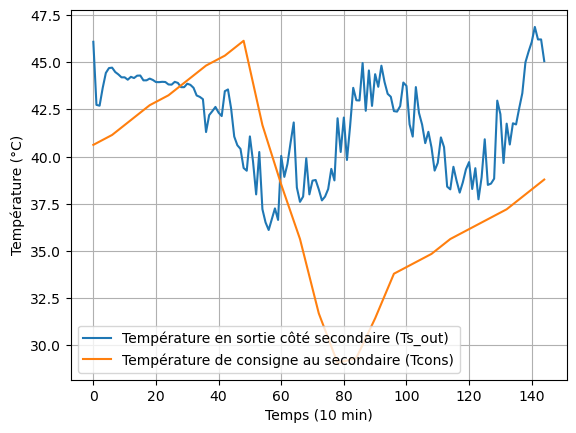

In [15]:
plt.clf()
ax_t = np.arange(0,temps_simu)
plt.plot(ax_t, Ts_out, label = "Température en sortie côté secondaire (Ts_out)")
plt.plot(ax_t, Tcons, label = "Température de consigne au secondaire (Tcons)")
plt.legend()
plt.xlabel('Temps (10 min)')
plt.ylabel('Température (°C)')
plt.grid(True)
plt.show()


## Mise en place de la régulation 

Afin d'adapter la température de sortie de l'échangeur côté secondaire, on installe une vanne de réglage côté primaire qui permet de moduler le débit côté primaire entre 0 et 100% du débit nominal. On notera _Youv_ le pourcentage d'ouverture de cette vanne qui se modélise simplement par l'équation :
*<center> Mp = Youv * Mp_nom </center>*

L'ouverture de la vanne est réglée à l'aide d'un régulateur proportionnel, dont le rôle est, à partir de l’écart entre la température de départ côté secondaire et la température de consigne, de calculer de combien la vanne doit s’ouvrir ou se fermer à chaque pas de temps.
L'incrément d'ouverture (ou de fermeture) de la vanne _Youv_inc_ est donné par l'équation suivante :  


<div style="width:600px;margin:auto; margin:auto;">
<center>

![alt text](<Images/equ régulation proportionnelle.jpg>)
<center/>
</div> 

A chaque pas de temps, on calcule donc l'incrément d'ouverture ou de fermeture de la vanne pour le pas de temps suivant (on parle de schéma numérique explicite). La valeur du gain du contrôleur dépend donc directement de ce schéma numérique, et plus particulièrement du pas de temps considéré. Dans notre exemple, on prendra une valeur de _Kp_ comprise entre 0.001 et 0.01.


*<ins>Question 4</ins> : Compléter le code rédigé à la question 3 pour régler l'ouverture de la vanne et atteindre la température de consigne demandée en sortie de l'échangeur*

La température en entrée côté primaire est de 50°C (constante)

In [16]:
Kp=0.003 #0.003

Text = np.array(Input['Text']) # Vecteur des températures extérieures
P_SST = np.array(Input['P (W)']) # Vecteur des puissances appelées côté secondaire

Tp_in = 50*np.ones(int(temps_simu))
Ts_out = np.zeros(int(temps_simu)) # Vecteur des températures de sortie côté secondaire 
Tp_out = np.zeros(int(temps_simu)) # Vecteur des températures de sortie côté primaire 
Tcons = np.zeros(int(temps_simu)) # Vecteur des températures de consigne côté secondaire 
ecart_T = np.zeros(int(temps_simu)) # Vecteur des erreurs de régulation
Youv = 0.25*np.ones(int(temps_simu)) # Vecteur des ouvertures de vannes (initialisation à 50% d'ouverture)
Mp = 0.5*Mp_nom*np.ones(int(temps_simu)) #Vecteur des débits coté primaire (initialisation à 50% du débit nominal)

a = (Ts_out_nom-15)/(-7-15)
b = Ts_out_nom-a*(-7)

for t in range(0,int(temps_simu)):
    Mp[t] = Youv[t]*Mp_nom 
    Tp_out[t] = Tp_in[t] - P_SST[t]/ (Mp[t] * Cp) 
    hpS = hpS_nom * (Mp[t] / Mp_nom)**(0.8) 
    UA = (1 / hpS + 1 / hsS_nom)**(-1) 
    NUT = UA /(Cp * Mp[t])
    R = Mp[t] / Mp_nom 
    if R==1:
        E = NUT/(1+NUT)
    else :
        E = (1 - exp(-NUT * (1 - R)))/(1- R * exp(-NUT * (1 - R)))  

    Ts_in = Tp_in[t] - P_SST[t]/(E*Mp[t]*Cp) 
    Ts_out[t] = Ts_in + P_SST[t]/(Mp_nom*Cp)

    Tcons[t] = a * Text[t] + b
    ecart_T[t]=Tcons[t]-Ts_out[t]

    Youv_inc = Kp*ecart_T[t] 
    
    if t<int(temps_simu)-1 :
        Youv[t+1]= Youv[t] + Youv_inc 
        Youv[t+1] = np.clip(Youv[t+1],0,1) 

    

**Sortie graphique**

*<ins> Question 5</ins> : Afficher la température de sortie de l'échangeur côté secondaire et la température de consigne.*

<Figure size 640x480 with 0 Axes>

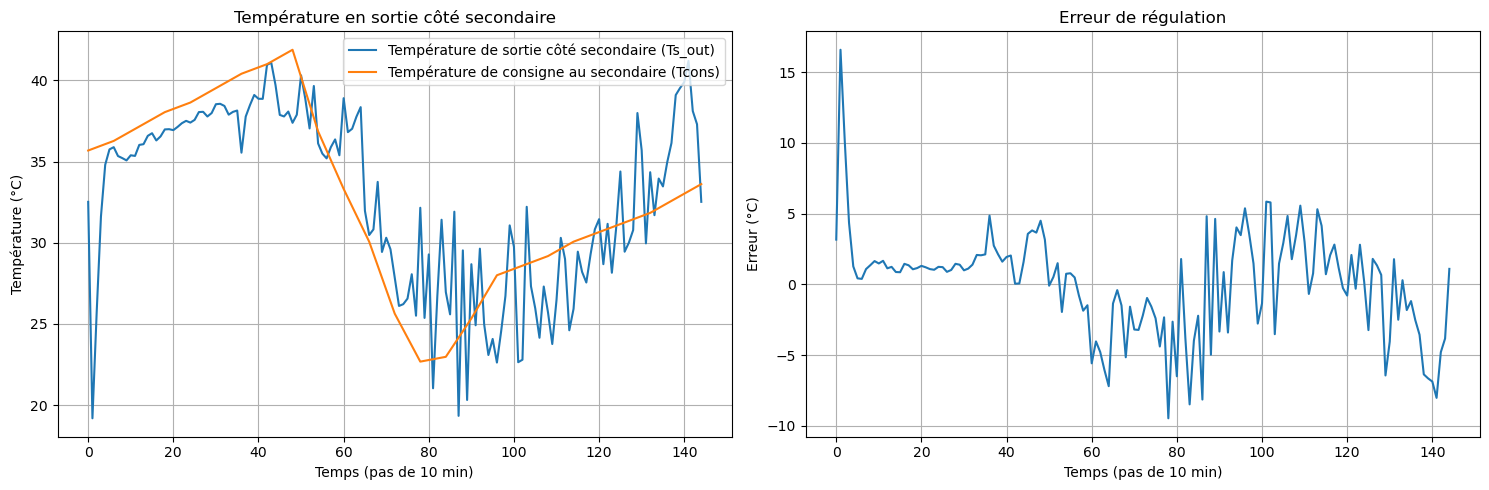

In [17]:
plt.clf()

ax_t = np.arange(0,int(temps_simu))


fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax0, ax1 = axes.flatten()
ax_t = np.arange(0,int(temps_simu))

ax0.plot(ax_t, Ts_out, label = 'Température de sortie côté secondaire (Ts_out)')
ax0.plot(ax_t, Tcons, label = 'Température de consigne au secondaire (Tcons)')
ax0.set_title('Température en sortie côté secondaire')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Temps (pas de 10 min)')
ax0.set_ylabel('Température (°C)')

ax1.plot(ax_t, ecart_T)
ax1.set_title('Erreur de régulation')
ax1.grid()
ax1.set_xlabel('Temps (pas de 10 min)')
ax1.set_ylabel('Erreur (°C)')
fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'